# Lab 4. Image Analysis

Images are provided with 



Use the thermal and multispectral data shared with you to develop/report the following: 

a. Boxplot showing the temperature data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

b. Boxplot showing the GNDVI data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

c.   Add discussion of 125-200 words discussing the data alongside some background information from literature and reference citations. (5 + 2)

In [60]:
%load_ext blackcellmagic
%matplotlib inline
import cv2 as cv
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import the images
# WT, ABAL, and OST22D Drought and Control
# ['data\\raw\\ABAL_Control.JPG', 'data\\raw\\ABAL_Drought.JPG', 'data\\raw\\OST22D_Control.JPG', 'data\\raw\\OST22D_Drought.JPG', 'data\\raw\\WT-Control.JPG', 'data\\raw\\WT_Drought.JPG']
# y, x, z
images = [cv.imread(str(imagepath), cv.IMREAD_UNCHANGED)[900:2800, 1250:4500, :] for imagepath in pathlib.Path('./data/raw/').glob('*.JPG')]    
print(images[0].shape)

# (NIR, G, B) order
images_ngb = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]

# # hsv images
# images_hsv = [cv.cvtColor(image, cv.COLOR_BGR2HSV) for image in images]

# grayscale images
images_grayscale = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]



(1900, 3250, 3)


In [3]:
# radiometric calibration
for i, image in enumerate(images_ngb):
    for band in range(0, 3):
        print(f"{i}:{band}, min: {np.min(image[0:1750,0:500,band])}, max: {np.max(image[0:1750,0:500,band])}")
# white is showing max 255 for all bands       


0:0, min: 31, max: 255
0:1, min: 55, max: 255
0:2, min: 56, max: 255
1:0, min: 16, max: 255
1:1, min: 35, max: 255
1:2, min: 37, max: 255
2:0, min: 20, max: 255
2:1, min: 39, max: 255
2:2, min: 43, max: 255
3:0, min: 1, max: 255
3:1, min: 29, max: 255
3:2, min: 32, max: 255
4:0, min: 29, max: 255
4:1, min: 50, max: 255
4:2, min: 50, max: 255
5:0, min: 10, max: 255
5:1, min: 40, max: 255
5:2, min: 41, max: 255


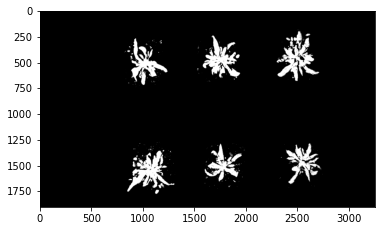

In [50]:
# segment image from background using hsv colorspace
# explore hsv space

def create_mask(img):
    """ takes an rgb image, converts it to hsv, creates and returns mask"""
    image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    sat = (80, 255)
    val = (235, 255)

    # NIR mask upper hue range
    lower_nir1 = np.array([0, sat[0], val[0]])
    higher_nir1 = np.array([40, sat[1], val[1]])
    mask1 = cv.inRange(image, lower_nir1, higher_nir1)

    # NIR mask lower hue range
    lower_nir2 = np.array([160, sat[0], val[0]])
    higher_nir2 = np.array([180, sat[1], val[1]])
    mask2 = cv.inRange(image, lower_nir2, higher_nir2)

    # segment out the background, close enough
    # seg_img = cv.bitwise_and(image, image, mask=(mask1 + mask2))
    # seg_img_nbg = cv.cvtColor(cv.cvtColor(seg_img, cv.COLOR_HSV2BGR), cv.COLOR_BGR2RGB)
    
    return mask1 + mask2

masks = [create_mask(image) for image in images_ngb]


plt.imshow(masks[0], cmap='gray')
# plt.imshow(images_ngb[1][:,:,0])


C:\Users\MAGNUS~1.WOO\AppData\Local\Temp/ipykernel_58716/3817000613.py:8: RuntimeWarning: invalid value encountered in true_divide
  gndvi = np.nan_to_num((nir - green) / (nir + green))


0.0 2.973333333333333


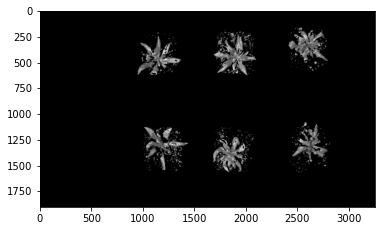

In [51]:
# calculate GNDVI
def get_GNDVI_img(img, mask):
    """ takes ngb image and a mask and calculates GNDVI index image"""
    image = img * np.dstack((mask, mask, mask))
    nir = image[:,:,0]
    green = image[:,:,1]

    gndvi = np.nan_to_num((nir - green) / (nir + green))

    return np.where(gndvi < 3, gndvi, 0)

gndvi_imgs = [get_GNDVI_img(img, mask) for img, mask in zip(images_ngb, masks)]

plt.imshow(gndvi_imgs[1], cmap="gray")
print(np.min(gndvi_imgs[1]), np.max(gndvi_imgs[1]))

2877 1
2877 1
4721 1
4420 1
5148 1
3348 1
3569 1


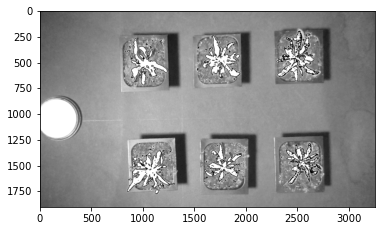

In [72]:
# find contours
def find_contours(mask):
    """used mask to find contours, return them"""
    contours, hierarchy = cv.findContours(
        image=mask, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE
    )
    print(len(contours), len(hierarchy))
    return contours


con = find_contours(mask=masks[0])


# plt.imshow(find_contours(gndvi_imgs[0]), cmap="gray")

images_ngb_contours = [
    cv.drawContours(
        image=image[:,:,0].copy(),
        contours=find_contours(mask),
        contourIdx=-1,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv.LINE_AA,
    )
    for image, mask in zip(images_ngb, masks)
]

plt.imshow(images_ngb_contours[0], cmap="gray")

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [ ]:
# functions
def load_img(self, channel_name: str):
        """open image file, replace all '-10000' transparent values with zero, and return"""
        image_path = glob.glob(
            os.path.join(
                self.params["data_import_path"], f"*{channel_name}.tif"
            )
        )[0]

        image = cv.imread(image_path, cv.IMREAD_UNCHANGED)

        out_image = np.where(
            image < 0, 0.0, image
        )  # gets rid of -10000 transparency
        return out_image

        # scaled_image = np.multiply(out_image, 255.0).astype(np.float32)

        # print(f"importing {channel_name}... done. dtype: {out_image.dtype}")
        # return scaled_image

    def crop_image(self, image: np.array, crop_percent: float):
        """takes image: np.array, and crop_percent: float, return a center cropped np.array"""
        h, w = image.shape
        h0 = int(h * (1 - crop_percent))
        h1 = int(h * crop_percent)
        w0 = int(w * (1 - crop_percent))
        w1 = int(w * crop_percent)
        print(h0, h1, w0, w1)
        return image[h0:h1, w0:w1]

    def show_image(self, image, size=(8, 30)):
        """plot array as img"""
        plt.figure(figsize=size)
        plt.imshow(image, cmap="viridis")

    def get_channel_names(self, path_list: list) -> list:
        """gets the channel name from the file path"""
        return [
            os.path.split(path)[1].split("_")[-1].split(".")[0]
            for path in path_list
        ]

    def calc_spec_idx(self, combo: tuple[int, int], bands: np.array):
        """calculates spectral index from channel nums of np.array
        NDSI = (band[0] - band[1]) / (band[0] + band[1])
        This function avoids divide by zero error."""
        band_a = bands[combo[0]]
        band_b = bands[combo[1]]

        numer = np.subtract(band_a, band_b)
        denom = np.add(band_a, band_b)
        return np.divide(
            numer, denom, out=np.zeros_like(numer), where=(denom != 0)
        )

    def ndsi_mean(
        self,
        arr: npt.NDArray,
        origin: tuple[int, int],
        shape: tuple[int, int],
        mask: npt.NDArray,
    ) -> float:
        """Return mean value for arr in the given region of interest.

        Origin and shape are (x, y), but the np.array is (y, x).

        Calculates mean using a boolean mask to exclude bg values.
        """

        roi_width, roi_height = shape
        roi_x, roi_y = origin

        return np.mean(
            a=arr[roi_y : roi_y + roi_height, roi_x : roi_x + roi_width],
            where=mask[roi_y : roi_y + roi_height, roi_x : roi_x + roi_width],
        )

a. Boxplot showing the temperature data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

b. Boxplot showing the GNDVI data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

c.   Add discussion of 125-200 words discussing the data alongside some background information from literature and reference citations. (5 + 2)